# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [86]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit

In [87]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [88]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [89]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [90]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

In [91]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

def fit(dataset):
    ages = calculate_ages(dataset)
    mortality_rate = calculate_mortality_rate(dataset)
    
    predicted_parameters = fit_gompertz_model(ages, mortality_rate)
    predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)
    return predicted_mortality

In [92]:
def plot_fitted_gompertz_curve(ages, mortality_rate, all_mortality_rate, single_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
    plt.plot(ages, single_mortality_rate, label='Single Gompertz Fit', color=COLOR_MAP[2])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

# Multi-Layer Perceptron

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class MortalityDataset(Dataset):
    def __init__(self, data_dict, samples):
        self.samples = samples

        for treatment_key, treatment_data in data_dict.items():
            age_values = treatment_data['x'].values
            mortality_rates = 1 - treatment_data['y'].values
            treatment_vector = self.create_treatment_vector(treatment_key)

            for age, mortality_rate in zip(age_values, mortality_rates):
                sample = {
                    'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
                    'output': torch.tensor([mortality_rate], dtype=torch.float32)
                }
                self.samples.append(sample)

    def create_treatment_vector(self, treatment_key):
        # Create a binary treatment vector for each treatment
        all_treatments = ['Rapamycin', 'HSCs', 'Gal-Nav', 'mTERT']
        treatment_vector = [1 if t in treatment_key else 0 for t in all_treatments]
        return treatment_vector

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Create the dataset
mortality_dataset = MortalityDataset(data_dict = female_dataset, samples = [])

# Create a DataLoader without batching as the data isnt too big
data_loader = DataLoader(mortality_dataset, batch_size=len(mortality_dataset), shuffle=True)

In [98]:
from sklearn.model_selection import train_test_split

# Model parameters
input_size = 5  # Age + Treatment vector size
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 5000

# Initialize model, loss function, and optimizer
model = MLPModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(mortality_dataset.samples, test_size=0.2, random_state=42)

# Create separate datasets for training and validation
train_dataset = MortalityDataset(data_dict= {},samples=train_data)
val_dataset = MortalityDataset(data_dict= {},samples=val_data)

# Create separate DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# Training loop
best_val_loss = float('inf')  # Initialize with a large value
best_model = None
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch in train_loader:
        inputs = batch['input']
        outputs = batch['output']

        # Forward pass
        predictions = model(inputs)
        # Compute loss
        loss = criterion(predictions, outputs)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_loss = 0.0
        for val_batch in val_loader:
            val_inputs = val_batch['input']
            val_targets = val_batch['output']

            val_predictions = model(val_inputs)
            val_loss += criterion(val_predictions, val_targets)

    # Calculate average validation loss
    val_loss /= len(val_loader)

    # Print the loss for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

    # Check if the current model has the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

# Use the best model for inference
model.load_state_dict(best_model)

Epoch 1/5000, Loss: 11755.3330078125, Val Loss: 10143.5078125
Epoch 2/5000, Loss: 9994.1591796875, Val Loss: 8507.693359375
Epoch 3/5000, Loss: 8382.3916015625, Val Loss: 7024.98779296875
Epoch 4/5000, Loss: 6921.484375, Val Loss: 5696.12548828125
Epoch 5/5000, Loss: 5612.4423828125, Val Loss: 4524.0615234375
Epoch 6/5000, Loss: 4457.74169921875, Val Loss: 3504.207763671875
Epoch 7/5000, Loss: 3452.885009765625, Val Loss: 2630.743408203125
Epoch 8/5000, Loss: 2592.22119140625, Val Loss: 1898.9093017578125
Epoch 9/5000, Loss: 1871.1103515625, Val Loss: 1302.51513671875
Epoch 10/5000, Loss: 1283.4541015625, Val Loss: 833.6133422851562
Epoch 11/5000, Loss: 821.4241333007812, Val Loss: 482.4708251953125
Epoch 12/5000, Loss: 475.42327880859375, Val Loss: 237.5579376220703
Epoch 13/5000, Loss: 234.0940704345703, Val Loss: 85.73155212402344
Epoch 14/5000, Loss: 84.48686981201172, Val Loss: 12.588470458984375
Epoch 15/5000, Loss: 12.409873962402344, Val Loss: 2.852769374847412
Epoch 16/5000, L

<All keys matched successfully>

In [95]:
# Test the trained model on new data
test_input = torch.tensor([580, 0, 0,0,0], dtype=torch.float32)  # Example input for testing
predicted_output = model(test_input)
print(f'Predicted Mortality Rate: {predicted_output.item()}')

Predicted Mortality Rate: 0.1819368302822113


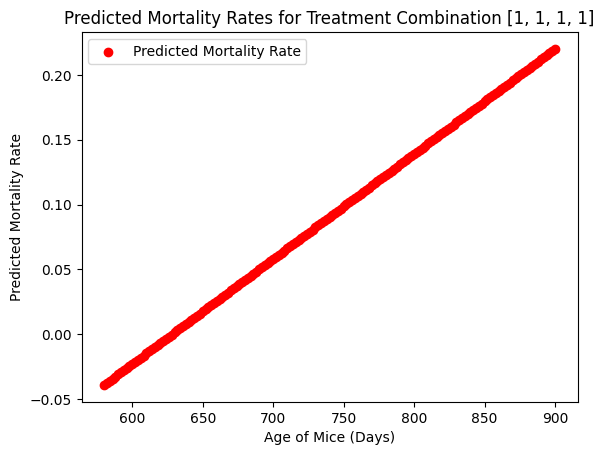

In [97]:
# Define the treatment combination
treatment_combo = [1, 1, 1, 1]

# Create input data for the specified treatment combination and age range (580 - 900 days)
ages_to_predict = np.arange(580, 901, 2)
input_data = []

for age in ages_to_predict:
    treatment_vector = treatment_combo
    sample = {
        'input': torch.tensor([age] + treatment_vector, dtype=torch.float32),
    }
    input_data.append(sample)

# Convert input_data to a DataLoader for batch processing
prediction_data_loader = DataLoader(input_data, batch_size=len(input_data), shuffle=False)
# Set the model to evaluation mode
model.eval()

# Make predictions
predictions = []
with torch.no_grad():
    for batch in prediction_data_loader:
        inputs = batch['input']
        output = model(inputs)
        predictions.extend(output.squeeze().tolist())
        
        # Plot the predicted mortality rates
plt.scatter(ages_to_predict, predictions, label='Predicted Mortality Rate', color='red')
plt.xlabel('Age of Mice (Days)')
plt.ylabel('Predicted Mortality Rate')
plt.title('Predicted Mortality Rates for Treatment Combination ' + str(treatment_combo))
plt.legend()
plt.show()
